In [19]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo
from flygym.terrain.mujoco_terrain import ExtrudingBlocksTerrain

from tqdm import trange
from flygym.util.config import all_leg_dofs

from scipy.signal import medfilt
from scipy.integrate import ode

import PIL.Image

In [20]:
# Initialize simulation
run_time = 1
out_dir = Path('../CPGs')

#friction between the fly and the ground
friction = 1.0

physics_config = {
    'joint_stiffness': 2500,
    'friction': (friction, 0.005, 0.0001),
    'gravity': (0, 0, -9.81e5)}
terrain_config = {'fly_pos': (0, 0, 600),
                  'friction': (friction, 0.005, 0.0001)}

nmf = NeuroMechFlyMuJoCo(render_mode='saved',
                         timestep=1e-4,
                         render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left_top'},
                         init_pose='stretch',
                         actuated_joints=all_leg_dofs,
                         terrain='blocks')

num_steps_base = int(run_time / nmf.timestep)

In [21]:

legs = ["RF", "RM", "RH", "LF", "LM", "LH"]
n_oscillators = len(legs)

dt = nmf.timestep  # seconds
t = np.arange(0, run_time, dt)

# lets say we want 10 oscillations in the time period
n_steps = 10
frequencies = np.ones(n_oscillators) * n_steps / run_time

# For now each oscillator have the same amplitude
target_amplitude = 1.0
target_amplitudes = np.ones(n_oscillators) * target_amplitude
#rate of change of the amplitude for each oscillator
rate = 10
rates = np.ones(n_oscillators) * rate

# Here we just build a chain of oscillators form 1 to 6
# They all have a bias of pi/6 from one to the other
bias = np.pi/3
# bias only above or bellow the main diagonal => only coupling between neighbouring oscillators
phase_biases = np.diag(np.ones(n_oscillators-1)*bias,k=1) - np.diag(np.ones(n_oscillators-1) * bias, k=-1)

# We wont play with the coupling weights yet so lets set it as the same as the phase biases
# As a consequence the oscillators that have a phase difference of zero are not coupled (depending on your implementation you might want to change that)
coupling_weights = (np.abs(phase_biases) > 0).astype(float) * 10.0 #* 10.0

In [22]:
def phase_oscillator(_time, state):
    """Phase oscillator model used in Ijspeert et al. 2007"""
    
    # current state of the oscillator with phases and amplitudes
    phases = state[:n_oscillators]
    amplitudes = state[n_oscillators:2*n_oscillators]

    # NxN matrix with the phases of the oscillators, each row copy of the phases vector
    phase_matrix = np.tile(phases, (n_oscillators, 1))

    # NxN matrix with the amplitudes of the oscillators, each row copy of the amplitudes vector
    amp_matrix = np.tile(amplitudes, (n_oscillators, 1))

    freq_contribution = 2*np.pi*frequencies

    #  scaling of the phase differences between oscillators by the amplitude of the oscillators and the coupling weights
    scaling = np.multiply(amp_matrix, coupling_weights)

    # phase matrix and transpose substraction are analogous to the phase differences between oscillators, those should be close to the phase biases
    phase_shifts_contribution = np.sin(phase_matrix-phase_matrix.T-phase_biases)

    # Here we compute the contribution of the phase biases to the derivative of the phases
    # we mulitply two NxN matrices and then sum over the columns (all j oscillators contributions) to get a vector of size N 
    coupling_contribution = np.sum(np.multiply(scaling, phase_shifts_contribution), axis=1)

    # Here we compute the derivative of the phases given by the equations defined previously. 
    # We are using for that matrix operations to speed up the computation
    dphases =  freq_contribution + coupling_contribution
    
    damplitudes = np.multiply(rates, target_amplitudes-amplitudes)
    
    return np.concatenate([dphases, damplitudes])

def sine_output(phases, amplitudes):
        return amplitudes * (1 + np.cos(phases))

In [23]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

In [24]:
# Interpolate 5x
step_duration = len(data['joint_LFCoxa'])
# number of samples in the step duration
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
# holds the interpolated data for all joints
step_data_block_base = np.zeros((len(nmf.actuated_joints), interp_step_duration))
# time at which each joint angle was measured
measure_t = np.arange(step_duration) * data['meta']['timestep']
#time at which we want to interpolate the data
interp_t = np.arange(interp_step_duration) * nmf.timestep

# Interpolate data for each joint at the higher frequency
for i, joint in enumerate(nmf.actuated_joints):
    step_data_block_base[i, :] = np.interp(interp_t, measure_t, data[joint])

In [25]:
step_data_block_manualcorrect = step_data_block_base.copy()

for side in ["L", "R"]:
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}MCoxa")] += np.deg2rad(10) # Protract the midlegs: angle of midleg coxa increased by 10 degrees causing the leg to be more extended -> move forward
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}HFemur")] += np.deg2rad(-5) # Retract the hindlegs: angle of hindleg femur decreased by 5 degrees causing the leg to be more flexed -> move backward
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}HTarsus1")] -= np.deg2rad(15) # Tarsus more parallel to the ground (flexed) (also helps with the hindleg retraction): angle of hindleg tarsus1 decreased by 15 degrees causing the leg to be more flexed 
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}FFemur")] += np.deg2rad(15) # Protract the forelegs (slightly to conterbalance Tarsus flexion): angle of foreleg femur increased by 15 degrees causing the leg to be more extended -> move forward
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}FTarsus1")] -= np.deg2rad(15) # Tarsus more parallel to the ground (flexed) (add some retraction of the forelegs): angle of foreleg tarsus1 decreased by 15 degrees causing the leg to be more flexed


In [26]:
n_joints = len(nmf.actuated_joints)

leg_ids = np.arange(len(legs)).astype(int)
joint_ids = np.arange(n_joints).astype(int)
# Map the id of the joint to the leg it belongs to (usefull to go through the steps for each legs)
match_leg_to_joints = np.array([i  for joint in nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])


def advancement_transfer(phases, step_dur=interp_step_duration):
    """From phase define what is the corresponding timepoint in the joint dataset
    In the case of the oscillator, the period is 2pi and the step duration is the period of the step
    We have to match those two"""

    period = 2*np.pi
    #match length of step to period phases should have a period of period mathc this perios to the one of the step
    t_indices = np.round(np.mod(phases*step_dur/period, step_dur-1)).astype(int)
    t_indices = t_indices[match_leg_to_joints]
    
    return t_indices


# A dictionary to keep track of the state of each leg
leg_state = {
    'L': 'off_block',
    'R': 'off_block',
    # add additional leg identifiers as needed
}

# Adjust your advancement function to take into account the leg state
def advancement_transfer_with_block_state(phases, leg_state, step_dur=interp_step_duration):
    """From phase define what is the corresponding timepoint in the joint dataset
    In the case of the oscillator, the period is 2pi and the step duration is the period of the step
    We have to match those two"""
    
    period = 2*np.pi
    t_indices = np.round(np.mod(phases*step_dur/period, step_dur-1)).astype(int)
    
    # Modify indices based on leg state
    for i, leg_id in enumerate(leg_state.keys()):
        if leg_state[leg_id] == 'on_block':
            t_indices[i] = on_block_movement(leg_id, t_indices[i])
        else:
            t_indices[i] = off_block_movement(leg_id, t_indices[i])
    
    t_indices = t_indices[match_leg_to_joints]
    
    return t_indices

# Add your on_block_movement and off_block_movement functions here
def on_block_movement(leg_id, t_index):
    # Modify t_index based on the leg being on a block
    return t_index

def off_block_movement(leg_id, t_index):
    # Modify t_index based on the leg being off a block
    return t_index


In [27]:
# The bias matrix is define as follow: each line is the i oscillator and each column is the j oscillator couplign goes from i to j
# We express the bias in percentage of cycle 
# rows ad columns correspond to legs of the robot and each value is the phase bias between the two legs. Diagonal is 0 
phase_biases_measured= np.array([[0, 0.425, 0.85, 0.51, 0, 0],
                                  [0.425, 0, 0.425, 0, 0.51, 0],
                                  [0.85, 0.425, 0, 0, 0, 0.51],
                                  [0.51, 0, 0, 0, 0.425, 0.85],
                                  [0, 0.51, 0, 0.425, 0, 0.425],
                                  [0, 0, 0.51, 0.85, 0.425, 0]])
                                
phase_biases_idealized = np.array([[0, 0.5, 1.0, 0.5, 0, 0],
                                   [0.5, 0, 0.5, 0, 0.5, 0],
                                   [1.0, 0.5, 0, 0, 0, 0.5],
                                   [0.5, 0, 0, 0, 0.5, 1.0],
                                   [0, 0.5, 0, 0.5, 0, 0.5],
                                   [0, 0, 0.5, 1.0, 0.5, 0]]) 
# Phase bias of one is the same as zero (1 cycle difference)
# If we would use a phase bias of zero, we would need to change the coupling weight strategy

phase_biases = phase_biases_idealized * 2 * np.pi

coupling_weights = (np.abs(phase_biases) > 0).astype(float) * 10.0 #* 10.0

In [28]:
block_height_threshold =300

np.random.seed(42)

_ = nmf.reset()

solver = ode(f=phase_oscillator)
solver.set_integrator('dop853')
initial_values = np.random.rand(2*n_oscillators)
solver.set_initial_value(y=initial_values, t=nmf.curr_time)

n_stabilisation_steps = 1000
num_steps = n_stabilisation_steps + num_steps_base

phases = np.zeros((num_steps, n_oscillators))
amplitudes = np.zeros((num_steps, n_oscillators))

joint_angles = np.zeros((num_steps, n_joints))

obs_list_tripod = []

# add an array to store the position data of the feet
position_data = np.zeros((6, num_steps))
# add an array to store the position data of the thorax 
fly_pos = np.zeros(num_steps)

for i in range(num_steps):
    res = solver.integrate(nmf.curr_time)
    phase = res[:n_oscillators]
    amp = res[n_oscillators:2*n_oscillators]

    phases[i, :] = phase
    amplitudes[i, :] = amp 

    if i > n_stabilisation_steps:
        indices = advancement_transfer_with_block_state(phase, leg_state)

        # Create a separate step_data_block_manualcorrect for each iteration
        step_data_block_manualcorrect_iter = step_data_block_manualcorrect.copy()
        
        # Get legs not on block
        legs_below_surface = np.where(position_data[:, i] < block_height_threshold)[0]

        # Update step_data_block_manualcorrect_iter for each leg not on block
        for leg_id in legs_below_surface:
            leg = legs[leg_id]
            
            step_data_block_manualcorrect_iter[nmf.actuated_joints.index(f"joint_{leg}Femur")] += np.deg2rad(-5)
            step_data_block_manualcorrect_iter[nmf.actuated_joints.index(f"joint_{leg}Tarsus1")] -= np.deg2rad(10)

        action = {'joints': step_data_block_manualcorrect_iter[joint_ids, 0] +
                (step_data_block_manualcorrect_iter[joint_ids, indices] -
                step_data_block_manualcorrect_iter[joint_ids, 0]) * amp[match_leg_to_joints]}
    else:
        action = {'joints': step_data_block_manualcorrect[joint_ids, 0]}
        
    obs, info = nmf.step(action)

    # Store the position data of the feet and thorax (z-axis only)
    position_data[:, i] = obs['end_effectors'][2::3]
    fly_pos[i] = obs['fly'][0][2]

    obs_list_tripod.append(obs)
    joint_angles[i, :] = action['joints']
    
    nmf.render()

nmf.save_video(out_dir / "tripod_block_3.mp4")

/Users/annalasne/opt/anaconda3/envs/flygym/lib/python3.8/site-packages/scipy/integrate/_ode.py:1179: UserWarning: dop853: step size becomes too small
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


In [29]:
from ipywidgets import Video
Video.from_file(out_dir / 'tripod_block_3.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

In [31]:
pos_block_adjusted = fly_pos

In [32]:
def advancement_transfer(phases, step_dur=interp_step_duration):
    """From phase define what is the corresponding timepoint in the joint dataset
    In the case of the oscillator, the period is 2pi and the step duration is the period of the step
    We have to match those two"""

    period = 2*np.pi
    #match length of step to period phases should have a period of period mathc this perios to the one of the step
    t_indices = np.round(np.mod(phases*step_dur/period, step_dur-1)).astype(int)
    t_indices = t_indices[match_leg_to_joints]
    
    return t_indices

In [33]:
np.random.seed(42)

_ = nmf.reset()

# Set solver
solver = ode(f=phase_oscillator)
solver.set_integrator('dop853')
initial_values = np.random.rand(2*n_oscillators)
solver.set_initial_value(y=initial_values, t=nmf.curr_time)

n_stabilisation_steps = 1000
num_steps = n_stabilisation_steps + num_steps_base

phases = np.zeros((num_steps, n_oscillators))
amplitudes = np.zeros((num_steps, n_oscillators))

joint_angles = np.zeros((num_steps, n_joints))

obs_list_tripod = []
fly_pos = np.zeros(num_steps)

for i in range(num_steps):

    res = solver.integrate(nmf.curr_time)
    phase = res[:n_oscillators]
    amp = res[n_oscillators:2*n_oscillators]

    phases[i, :] = phase
    amplitudes[i, :] = amp    

    if i> n_stabilisation_steps:
        indices = advancement_transfer(phase)
        # scale the amplitude of the joint angles to the output amplitude (High values of amplitude will highly alter the steps) 
        # With an amplitude of one, the joint angles will be the same as the one from the base step
        # With an amplitude of zero, the joint angles will be the same as the zero inidices of the base step (default pose)
        # The rest is a linear interpolation between those two
        action = {'joints': step_data_block_manualcorrect[joint_ids, 0] + \
                  (step_data_block_manualcorrect[joint_ids, indices]-step_data_block_manualcorrect[joint_ids, 0])*amp[match_leg_to_joints]}
        #action = {'joints': step_data_block_base[joint_ids, indices]}
    else:
        action = {'joints': step_data_block_manualcorrect[joint_ids, 0]}

    joint_angles[i, :] = action['joints']
    
    obs, info = nmf.step(action)
    fly_pos[i] = obs['fly'][0][2]
    obs_list_tripod.append(obs)
    nmf.render()

nmf.save_video(out_dir / "tripod_gap_without_change.mp4")

In [35]:
from ipywidgets import Video
Video.from_file(out_dir / 'tripod_gap_without_change.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

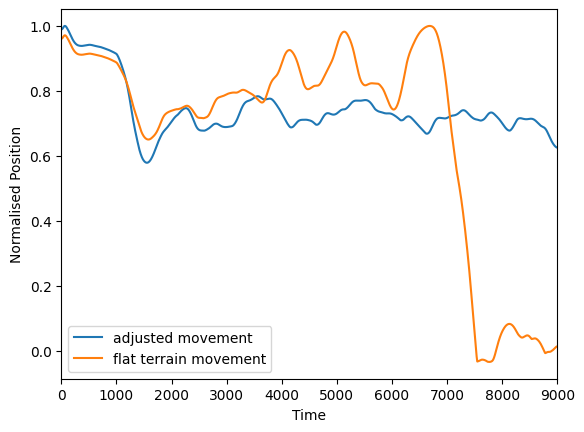

In [34]:
#plot pos_block_changes and fly_pos normalised
plt.plot(pos_block_adjusted /np.max(pos_block_adjusted ))
plt.plot(fly_pos/np.max(fly_pos))

#xlim since for fly_pos the fly falls down
plt.xlim(0, 9000)

#label
plt.xlabel('Time')
plt.ylabel('Normalised Position')

#put legend
plt.legend(['adjusted movement', 'flat terrain movement'])